In [1]:
import nilearn
from nilearn import datasets
from tqdm.notebook import tqdm

from graphUtils import *

## 0.1. Loading Atlas

In [2]:
atlas = datasets.fetch_atlas_aal(data_dir="/ptmp/arassat/nilearn_data")
atlas_filename = atlas.maps
labels = atlas.labels
print("The Atlas of choice has {} labels.".format(len(labels)))

The Atlas of choice has 116 labels.


## 0.2. Loading connectivity matrices to numpy arrays

In [3]:
import numpy as np
from nilearn import plotting

num_atlas_reg = len(labels)
num_subjects_tot = 115

subjects_removed = [6, 13, 45, 64, 78, 80, 88, 98, 105, 108, 113]
subjects = [i for i in range(1, num_subjects_tot + 1)]

for i in subjects_removed:
    subjects.remove(i)

num_subjects = num_subjects_tot - len(subjects_removed)

data_OFF = np.zeros((num_atlas_reg, num_atlas_reg, num_subjects))
data_ON = np.zeros((num_atlas_reg, num_atlas_reg, num_subjects))
print(data_OFF.shape)

for i, subject in enumerate(subjects):
    if subject < 10:
        file_str_OFF = "/ptmp/arassat/Abel/connectivity_matrices_aal/00%d_OFF_aal_connectivity.csv" % (subject)
        file_str_ON = "/ptmp/arassat/Abel/connectivity_matrices_aal/00%d_ON_aal_connectivity.csv" % (subject)
        data_OFF[:, :, i-1] = np.genfromtxt(file_str_OFF,delimiter=',')[1:,1:]
        data_ON[:, :, i-1] = np.genfromtxt(file_str_ON,delimiter=',')[1:,1:]
    elif subject >= 10 and subject < 100:
        file_str_OFF = "/ptmp/arassat/Abel/connectivity_matrices_aal/0%d_OFF_aal_connectivity.csv" % (subject)
        file_str_ON = "/ptmp/arassat/Abel/connectivity_matrices_aal/0%d_ON_aal_connectivity.csv" % (subject)
        data_OFF[:, :, i-1] = np.genfromtxt(file_str_OFF,delimiter=',')[1:,1:]
        data_ON[:, :, i-1] = np.genfromtxt(file_str_ON,delimiter=',')[1:,1:]
    else:
        file_str_OFF = "/ptmp/arassat/Abel/connectivity_matrices_aal/%d_OFF_aal_connectivity.csv" % (subject)
        file_str_ON = "/ptmp/arassat/Abel/connectivity_matrices_aal/%d_ON_aal_connectivity.csv" % (subject)
        data_OFF[:, :, i-1] = np.genfromtxt(file_str_OFF,delimiter=',')[1:,1:]
        data_ON[:, :, i-1] = np.genfromtxt(file_str_ON,delimiter=',')[1:,1:]
    
    np.fill_diagonal(data_OFF[:,:,i-1],0)
    np.fill_diagonal(data_ON[:,:,i-1],0)

    # removing the negative correlation values
    data_OFF[:,:,i-1] = np.where(data_OFF[:,:,i-1] > 0, data_OFF[:,:,i-1], 0)
    data_ON[:,:,i-1] = np.where(data_ON[:,:,i-1] > 0, data_ON[:,:,i-1], 0)

data = {
    "Off" : data_OFF,
    "On"  : data_ON
}

(116, 116, 104)


# 1. Generating proportional thresholds & null-hyposthesis networks

In [6]:
import bct
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Setting the proportional thresholds
# In T. Xu et al. thresholds = np.arange(0.1, 0.51, 0.01)
thresholds = np.arange(0.05, 0.51, 0.01)
thresholds_wei_test = np.arange(0.05, 0.51, 0.01)
num_thresholds = thresholds.size
num_thresholds_wei_test = thresholds_wei_test.size
# random seed for generating null-hypothesis networks
seed = 42
"""
# network will be saved in dictionaries
thresholded_data = {
    "Off" : np.zeros((num_atlas_reg, num_atlas_reg, num_subjects, num_thresholds)),
    "On"  : np.zeros((num_atlas_reg, num_atlas_reg, num_subjects, num_thresholds))
}
null_data = {
    "Off"  :  np.zeros(thresholded_data["Off"].shape),
    "On"   :  np.zeros(thresholded_data["On"].shape)
}
"""
thresholded_data_dist = {
    "Off" : np.zeros((num_atlas_reg, num_atlas_reg, num_subjects, num_thresholds_wei_test)),
    "On"  : np.zeros((num_atlas_reg, num_atlas_reg, num_subjects, num_thresholds_wei_test))
}
null_data_dist = {
    "Off"  :  np.zeros(thresholded_data_dist["Off"].shape),
    "On"   :  np.zeros(thresholded_data_dist["On"].shape)
}

In [7]:
print(null_data_dist["Off"].shape)

(116, 116, 104, 46)


## 1.1. Binarized Networks

In [ ]:
"""
for i in tqdm(range(num_subjects), leave=False):
    for j, th in tqdm(enumerate(thresholds), leave=False):
        thresholded_data["Off"][:, :, i, j] = bct.weight_conversion(bct.threshold_proportional(data["Off"][:, :, i], th, copy=True), wcm='binarize', copy=True)
        thresholded_data["On"][:, :, i, j] = bct.weight_conversion(bct.threshold_proportional(data["On"][:, :, i], th, copy=True), wcm='binarize', copy=True)
        
# saving the networks
np.savez('thresholded_data.npz', thresholded_data_Off=thresholded_data["Off"], thresholded_data_On=thresholded_data["On"])
"""

In [ ]:
"""
for i in tqdm(range(num_subjects)):
    for j, th in tqdm(enumerate(thresholds), leave=False):
        null_data["Off"][:, :, i, j],_  = bct.reference.null_model_und_sign(thresholded_data["Off"][:, :, i, j], seed=seed)
        
# saving the networks
np.savez('null_data_Off.npz', null_data_Off=null_data["Off"])
"""

In [ ]:
"""
for i in tqdm(range(num_subjects)):
    for j, th in tqdm(enumerate(thresholds), leave=False):
        null_data["On"][:, :, i, j],_  = bct.reference.null_model_und_sign(thresholded_data["On"][:, :, i, j], seed=seed)

# saving the networks
np.savez('null_data_On.npz', null_data_On=null_data["On"])
"""

## 1.2. Weighted Networks

In [8]:
# As Skidmore 2011, we threshold the weights and consider them as distances 
for i in tqdm(range(num_subjects), leave=False):
    for j, th in enumerate(thresholds_wei_test):
        thresholded_data_dist["Off"][:, :, i, j] = bct.weight_conversion(bct.threshold_proportional(data["Off"][:, :, i], th, copy=True), wcm='lengths', copy=True)
        thresholded_data_dist["On"][:, :, i, j] = bct.weight_conversion(bct.threshold_proportional(data["On"][:, :, i], th, copy=True), wcm='lengths', copy=True)
        
# saving the networks
np.savez('thresholded_data_dist.npz', thresholded_data_Off_dist=thresholded_data_dist["Off"], thresholded_data_On_dist=thresholded_data_dist["On"])

  0%|          | 0/104 [00:00<?, ?it/s]

In [9]:
for j in tqdm(range(len(thresholds_wei_test)), leave=False):
    for i in range(num_subjects):
        null_data_dist["Off"][:, :, i, j],_  = bct.reference.null_model_und_sign(thresholded_data_dist["Off"][:, :, i, j], seed=seed)
        
# saving the networks
np.savez('null_data_Off_dist.npz', null_data_Off_dist=null_data_dist["Off"])

  0%|          | 0/46 [00:00<?, ?it/s]

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


KeyboardInterrupt: 

In [27]:
for j in tqdm(range(len(thresholds_wei_test)), leave=False):
    for i in range(num_subjects):
        null_data_dist["On"][:, :, i, j],_  = bct.reference.null_model_und_sign(thresholded_data_dist["On"][:, :, i, j], seed=seed)
        
# saving the networks
np.savez('null_data_On_dist.npz', null_data_On_dist=null_data_dist["On"])

  0%|          | 0/104 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [28]:
print(null_data_dist['Off'].shape)
print(null_data_dist['On'].shape)

(116, 116, 104, 9)
(116, 116, 104, 9)


## Loading thresholded & null-hyposthesis networks

In [42]:
"""
# Binarized networks
data = np.load('thresholded_and_null_data.npz')
thresholded_data["Off"] = data['thresholded_data_Off']
thresholded_data["On"] = data['thresholded_data_On']
null_data["Off"] = data['null_data_Off']
null_data["On"] = data['null_data_On']

# Weighted networks
data_dist = np.load('thresholded_data_dist.npz')
thresholded_data_dist["Off"] = data_dist["thresholded_data_Off_dist"]
thresholded_data_dist["On"] = data_dist["thresholded_data_On_dist"]
null_data_dist['Off'] = np.load('null_data_Off_dist.npz')['null_data_Off_dist']
null_data_dist['On']  = np.load('null_data_On_dist.npz')['null_data_On_dist']
"""

# when networks generated separately due to high wall time for generation (dense thresholding) 
"""
th_data = np.load('thresholded_data.npz')
null_data_Off = np.load('null_data_Off.npz')
null_data_On = np.load('null_data_On.npz')
thresholded_data["Off"] = thresholded_data['thresholded_data_Off']
thresholded_data["On"] = thresholded_data['thresholded_data_On']
null_data["Off"] = null_data_Off['null_data_Off']
null_data["On"] = null_data_On['null_data_On']
"""

'\nth_data = np.load(\'thresholded_data.npz\')\nnull_data_Off = np.load(\'null_data_Off.npz\')\nnull_data_On = np.load(\'null_data_On.npz\')\nthresholded_data["Off"] = thresholded_data[\'thresholded_data_Off\']\nthresholded_data["On"] = thresholded_data[\'thresholded_data_On\']\nnull_data["Off"] = null_data_Off[\'null_data_Off\']\nnull_data["On"] = null_data_On[\'null_data_On\']\n'

---

### Check that null-hypothesis network for the weighted case preserve strength distribution

In [59]:
"""
import bct

deg_distrib_null = bct.degrees_und(null_data_dist["On"][:, :, 0, 8])
deg_distrib = bct.degrees_und(thresholded_data_dist["On"][:, :, 0, 8])
"""

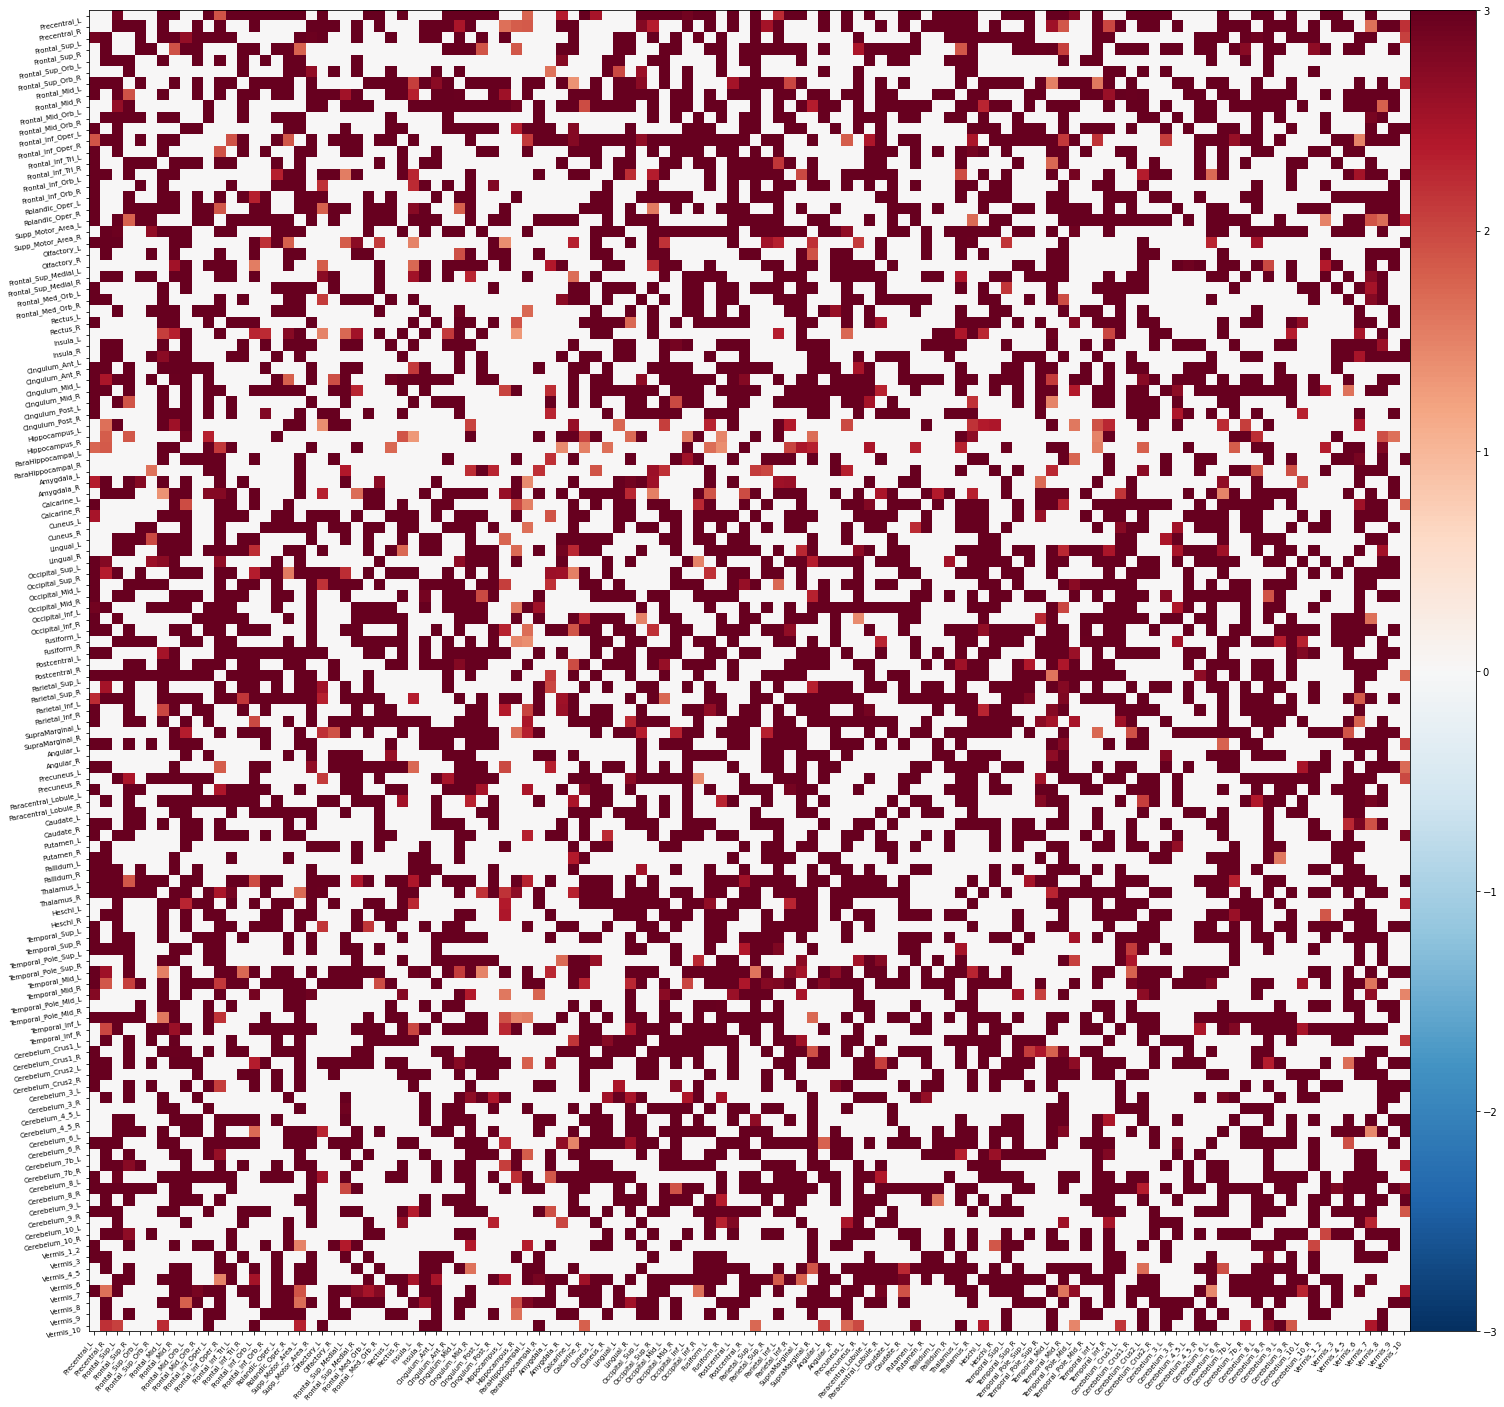

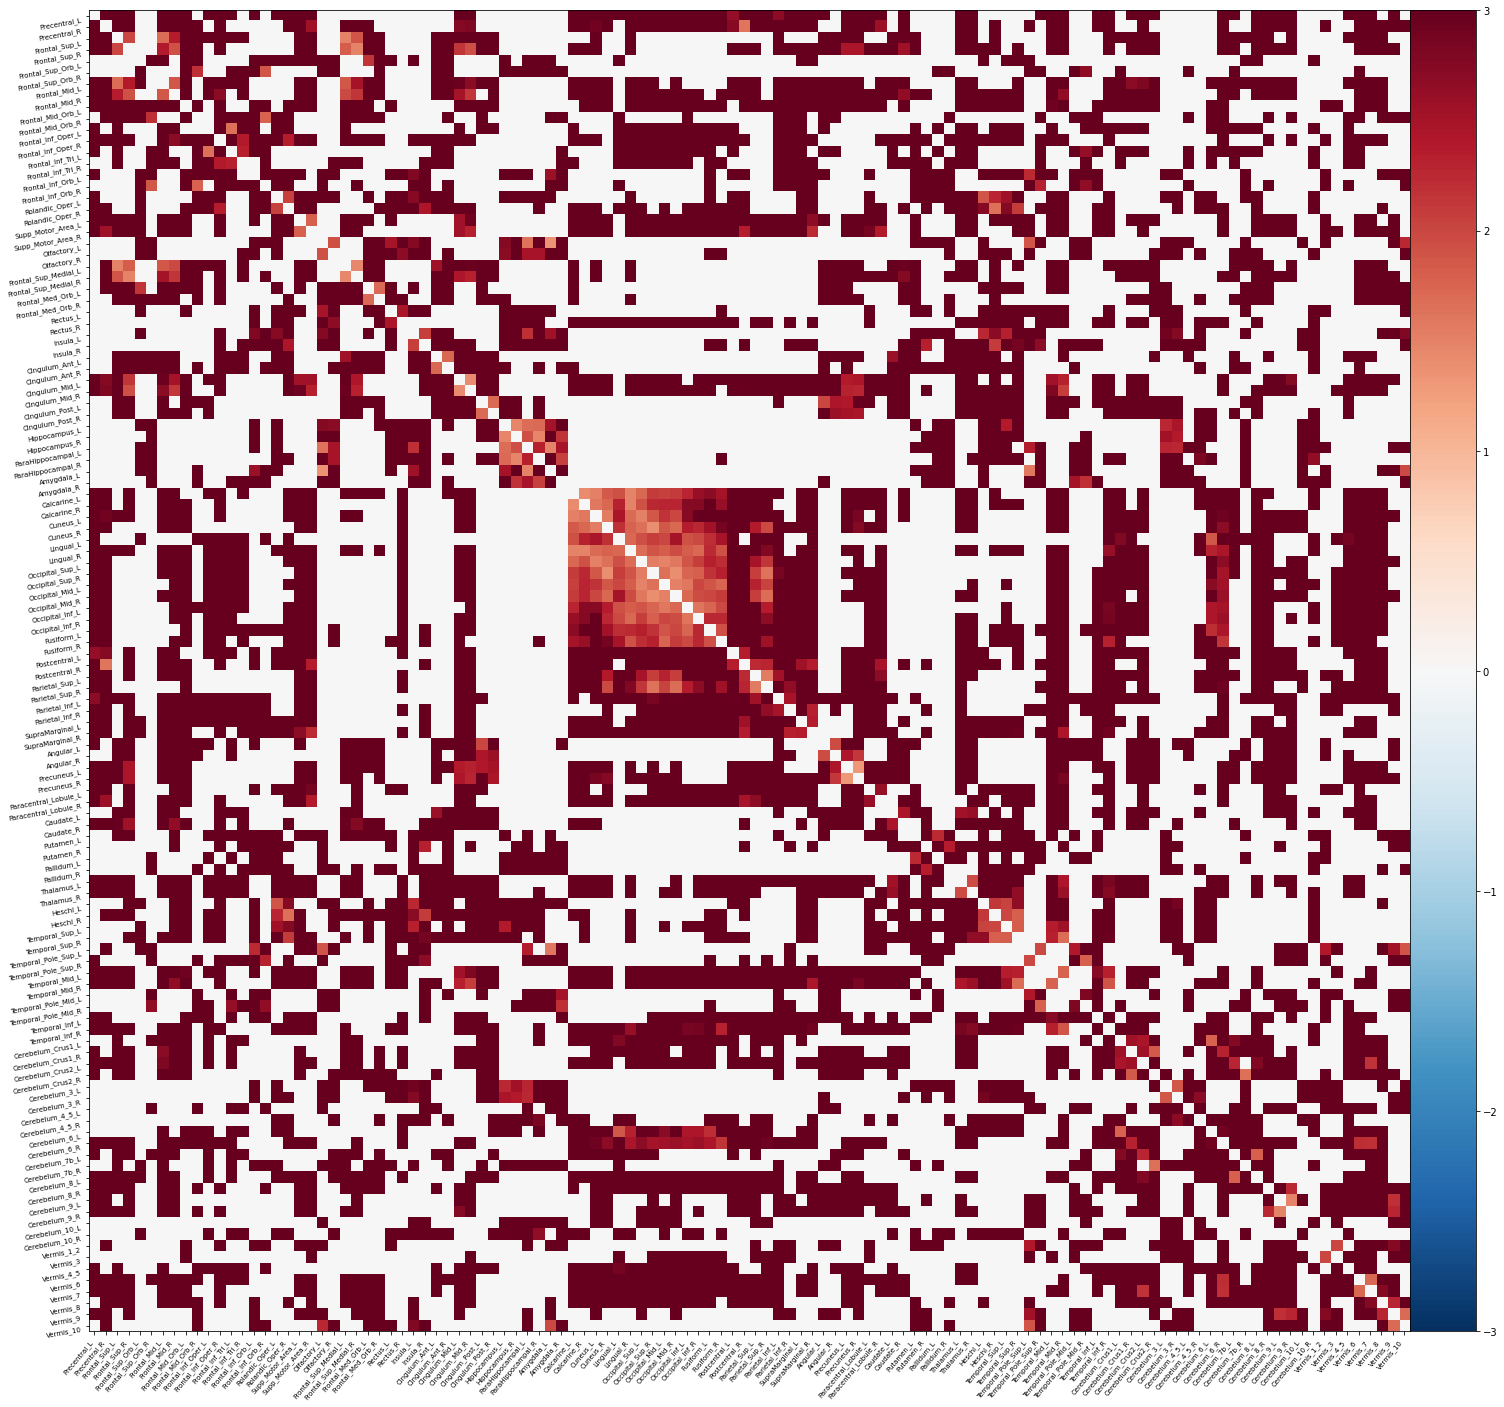

In [45]:
"""
# visualisation of a null-hypothesis network and original network both weighted side by side (same strength distribution)
plotting.plot_matrix(
    null_data_dist["On"][:, :, 0, 8], labels=labels, figure=(21, 21), colorbar=True, vmax=3, vmin=-3
)
plotting.plot_matrix(
    thresholded_data_dist["On"][:, :, 0, 8], labels=labels, figure=(21, 21), colorbar=True, vmax=3, vmin=-3
)
"""